In [1]:
import tensorflow as tf
import argparse
import pickle
import numpy as np
import sys
import cv2
import os
import matplotlib.pyplot as plt

from ssdutils import get_anchors_for_preset, decode_boxes, suppress_overlaps
from utils import draw_box
from tqdm import tqdm

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
graph_def = tf.GraphDef()
with open('model.pb', 'rb') as f:
    serialized = f.read()
    graph_def.ParseFromString(serialized)

In [3]:
with open('./pascal-voc/training-data.pkl', 'rb') as f:
    data = pickle.load(f)
    preset = data['preset']
    colors = data['colors']
    lid2name = data['lid2name']
    anchors = get_anchors_for_preset(preset)

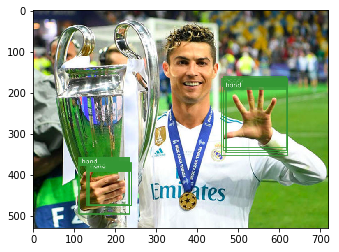

In [4]:
with tf.Session() as sess:
    
    tf.import_graph_def(graph_def, name='detector')
    img_input = sess.graph.get_tensor_by_name('detector/image_input:0')
    result = sess.graph.get_tensor_by_name('detector/result/result:0')
    
    batch = []
    batch_imgs = []
    
    img = cv2.imread('testIMG2.jpg')
    batch_imgs.append(img)
    
    img = cv2.resize(img, (300, 300))
    batch.append(img)
    
    batch = np.array(batch)
    feed = {img_input: batch}
    enc_boxes = sess.run(result, feed_dict=feed)
    
    for i in range(len(batch_imgs)):
        boxes = decode_boxes(enc_boxes[i], anchors, 0.3, lid2name, None)
        boxes = suppress_overlaps(boxes)[:10]
        
        for box in boxes:
            draw_box(batch_imgs[i], box[1], colors[box[1].label])
            
                
        
        batch_imgs[i] = cv2.cvtColor(batch_imgs[i], cv2.COLOR_BGR2RGB)
        plt.imshow(batch_imgs[i])